In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Double pendulum (with springs)

* $x_1 = (1 + r_1)\cos(\theta_1)$
* $y_1 = -(1 + r_1)\sin(\theta_1)$
* $x_2 = (1 + r_1)\cos(\theta_1) + (1 + r_2)\cos(\theta_2)$
* $y_2 = -(1 + r_1)\sin(\theta_1) - (1 + r_2)\sin(\theta_2)$
* $T = \frac{1}{2} m (\dot{x_1}^2 + \dot{y_1}^2 + \dot{x_2}^2 + \dot{y_2}^2)$
* $V = mg (y_1 + y_2) + \frac{1}{2} k (r_1^2 + r_2^2)$

Then the Lagrangian can be written as: 
* $L = T -V$

Then the lagrange's equations becomes: 
* $\frac{\partial L}{\partial \theta_j} - \frac{d}{dt}(\frac{\partial L}{\partial \dot{\theta_j}}) = 0$,Here $\theta_j = r_1,r_2,\theta_1,\theta_2$
* So we have 4 second order coupled differential equations to solve, which can simplify as 8 coupled first order PDEs

In [2]:
# define the constants that don't depend on time 
t, m, g, k = smp.symbols('t m g k')

In [3]:
# define the free variables and their derivatives wrt to time 
the1, the2, r1, r2 = smp.symbols(r'\theta_1, \theta_2, r_1, r_2', cls=smp.Function)

# theta1 and its derivatives 
the1 = the1(t)
the1_d = smp.diff(the1, t)
the1_dd = smp.diff(the1_d, t)
# theta2 and its derivatives 
the2 = the2(t)
the2_d = smp.diff(the2, t)
the2_dd = smp.diff(smp.diff(the2, t), t)
# r1 and its derivatives 
r1 = r1(t)
r1_d = smp.diff(r1, t)
r1_dd = smp.diff(smp.diff(r1, t), t)
# r2 and its derivatives 
r2 = r2(t)
r2_d = smp.diff(r2, t)
r2_dd = smp.diff(smp.diff(r2, t), t)

In [4]:
the1

\theta_1(t)

In [5]:
# define more variables 
x1, y1, x2, y2 = smp.symbols('x_1, y_1, x_2, y_2', cls=smp.Function)
x1= x1(the1, r1)
y1= y1(the1, r1)
x2= x2(the1, r1, the2, r2)
y2= y2(the1, r1, the2, r2)

In [6]:
# define x1,y1, x2 and y2 
x1 = (1+r1)*smp.cos(the1)
y1 = -(1+r1)*smp.sin(the1)
x2 = (1+r1)*smp.cos(the1) + (1+r2)*smp.cos(the2)
y2 = -(1+r1)*smp.sin(the1)-(1+r2)*smp.sin(the2)

In [7]:
# define the lagrangian 
T = 1/2 * m * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2 + smp.diff(x2, t)**2 + + smp.diff(y2, t)**2) #KE
V = m*g*y1 + m*g*y2 + 1/2 * k * r1**2 + 1/2 * k * r2**2 #PE (GPE+SPE)
L = T-V

In [8]:
# lagrange equation (thet1)
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t)
LE1 = LE1.simplify()

In [9]:
# lagrange equation (thet2)
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t)
LE2 = LE2.simplify()

In [10]:
# lagrange equation (r1)
LE3 = smp.diff(L, r1) - smp.diff(smp.diff(L, r1_d), t)
LE3 = LE3.simplify()

In [11]:
# lagrange equation (r2)
LE4 = smp.diff(L, r2) - smp.diff(smp.diff(L, r2_d), t)
LE4 = LE4.simplify()

In [12]:
# solve lagrange equations 
sols = smp.solve([LE1, LE2, LE3, LE4], (the1_dd, the2_dd, r1_dd, r2_dd),simplify=False, rational=False)

In [13]:
# convert sympy to numpy funtions 

dw1dt_f = smp.lambdify((m, k ,g, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d), sols[the1_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)

dw2dt_f = smp.lambdify((m, k ,g, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d), sols[the2_dd])
dthe2dt_f = smp.lambdify(the2_d, the2_d)

dv1dt_f = smp.lambdify((m, k ,g, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d), sols[r1_dd])
dr1dt_f = smp.lambdify(r1_d, r1_d)

dv2dt_f = smp.lambdify((m, k ,g, the1, the2, r1, r2, the1_d, the2_d, r1_d, r2_d), sols[r2_dd])
dr2dt_f = smp.lambdify(r2_d, r2_d)

In [14]:
the1_d

Derivative(\theta_1(t), t)

In [15]:
# define the function to solve the system of ODE
def dSdt(S, t):
    the1, w1, the2, w2, r1, v1, r2, v2 = S
    return [
        dthe1dt_f(w1),
        dw1dt_f(m,k,g,the1,the2,r1,r2,w1,w2,v1,v2),
        dthe2dt_f(w2),
        dw2dt_f(m,k,g,the1,the2,r1,r2,w1,w2,v1,v2),
        dr1dt_f(v1),
        dv1dt_f(m,k,g,the1,the2,r1,r2,w1,w2,v1,v2),
        dr2dt_f(v2),
        dv2dt_f(m,k,g,the1,the2,r1,r2,w1,w2,v1,v2),]

In [16]:
# solve the system of ODE using odeint 
t = np.linspace(0, 20, 1000)
g = 9.81
m=1
k=10
ans = odeint(dSdt, y0=[np.pi/2,0,(3/2)*np.pi/2,0,0,5,0,5], t=t)

Text(0, 0.5, '$\\theta$')

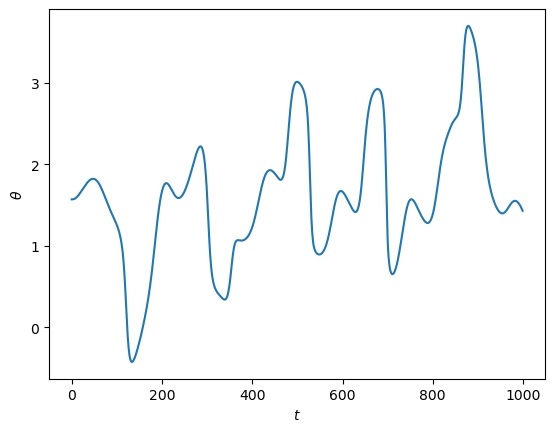

In [25]:
plt.plot(ans.T[0])
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta$')

Text(0, 0.5, '$\\dot{\\theta}$')

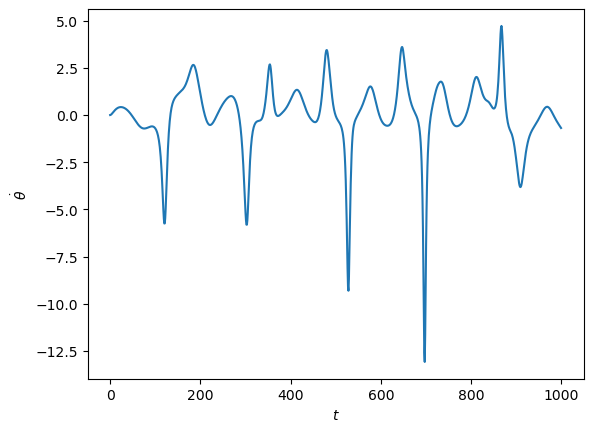

In [27]:
plt.plot(ans.T[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$\dot{\theta}$')